# Flax ogbg-molpcba Example

<a href="https://colab.research.google.com/github/google/flax/blob/main/examples/ogbg_molpcba/ogbg_molpcba.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstration notebook for
https://github.com/google/flax/tree/main/examples/ogbg_molpcba.

## Setup

In [1]:
# Install clu, ml-collections, latest Flax version, and tensorflow_datasets.
!pip install -U -q clu ml-collections git+https://github.com/google/flax tfds_nightly jraph

     |████████████████████████████████| 77 kB 2.7 MB/s 
     |████████████████████████████████| 88 kB 5.5 MB/s 
     |████████████████████████████████| 4.0 MB 38.2 MB/s 
     |████████████████████████████████| 73 kB 1.3 MB/s 
     |████████████████████████████████| 118 kB 38.3 MB/s 
     |████████████████████████████████| 57 kB 3.6 MB/s 


In [2]:
example_directory = 'examples/ogbg_molpcba'
editor_relpaths = ('configs/default.py', 'input_pipeline.py', 'models.py', 'train.py')

repo, branch = 'https://github.com/google/flax', 'main'

In [3]:
# (If you run this code in Jupyter[lab], then you're already in the
#  example directory and nothing needs to be done.)

#@markdown **Fetch newest Flax version and copy of example code.**
#@markdown
#@markdown **If you select no** below, then the files will be stored on the
#@markdown *ephemeral* Colab VM. **After some time of inactivity, this VM will
#@markdown be restarted and any changes will be lost**.
#@markdown
#@markdown **If you select yes** below, then you will be asked for your
#@markdown credentials to mount your personal Google Drive. In this case, all
#@markdown changes you make will *persist*. Even if you re-run this
#@markdown Colab notebook later on, the files will still exist. You can
#@markdown remove directories inside your Drive's `flax/` root if you want to
#@markdown manually revert these files.

if 'google.colab' in str(get_ipython()):
  import os
  os.chdir('/content')
  # Download Flax repo from Github.
  if not os.path.isdir('flaxrepo'):
    !git clone --depth=1 -b $branch $repo flaxrepo
  # Copy example files & change directory.
  mount_gdrive = 'no' #@param ['yes', 'no']
  if mount_gdrive == 'yes':
    DISCLAIMER = 'Note : Editing in your Google Drive, changes will persist.'
    from google.colab import drive
    drive.mount('/content/gdrive')
    example_root_path = f'/content/gdrive/My Drive/flax/{example_directory}'
  else:
    DISCLAIMER = 'WARNING : Editing in VM - changes lost after reboot!!'
    example_root_path = f'/content/{example_directory}'
    from IPython import display
    display.display(display.HTML(
        f'<h1 style="color:red;" class="blink">{DISCLAIMER}</h1>'))
  if not os.path.isdir(example_root_path):
    os.makedirs(example_root_path)
    !cp -r flaxrepo/$example_directory/* "$example_root_path"
  os.chdir(example_root_path)
  from google.colab import files
  for relpath in editor_relpaths:
    s = open(f'{example_root_path}/{relpath}').read()
    open(f'{example_root_path}/{relpath}', 'w').write(
        f'## {DISCLAIMER}\n' + '#' * (len(DISCLAIMER) + 3) + '\n\n' + s)
    files.view(f'{example_root_path}/{relpath}')

Cloning into 'flaxrepo'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 350 (delta 65), reused 140 (delta 20), pack-reused 0
Receiving objects: 100% (350/350), 2.10 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (65/65), done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Display current working directory.
# Note: In Colab, running the above cell changes the working directory.
!pwd

/content/examples/ogbg_molpcba


## Imports

In [5]:
# Base imports
from absl import logging
import flax
import jax.numpy as jnp
import jraph
from matplotlib import pyplot as plt
import numpy as np
import pprint
import tensorflow_datasets as tfds
logging.set_verbosity(logging.INFO)

In [6]:
# Local imports from current directory - auto reload.
# Any changes you make to train.py and other modules below will appear automatically.
%load_ext autoreload
%autoreload 2
import train
import input_pipeline
from configs import default as config_lib
config = config_lib.get_config()

## Dataset

TensorFlow Datasets supports customizable visualization of the ogbg_molpcba dataset.

In [7]:
# Visualization helpers
# Dictionaries used to map nodes and edges to colors.
atomic_numbers_to_elements = {
    6: 'C', 7: 'N', 8: 'O', 9: 'F', 14: 'Si',
    15: 'P', 16: 'S', 17: 'Cl', 35: 'Br',
}
elements_to_colors = {
    element: f'C{index}'
    for index, element in enumerate(atomic_numbers_to_elements.values())
}
bond_types_to_colors = {num: f'C{num}' for num in range(4)}

# Node colors are atomic numbers.
def node_color_fn(graph):
  atomic_numbers = 1 + graph['node_feat'][:, 0].numpy()
  return {
      index: elements_to_colors[atomic_numbers_to_elements[atomic_number]]
      for index, atomic_number in enumerate(atomic_numbers)
  }

# Node labels are element names.
def node_label_fn(graph):
  atomic_numbers = 1 + graph['node_feat'][:, 0].numpy()
  return {
      index: atomic_numbers_to_elements[atomic_number]
      for index, atomic_number in enumerate(atomic_numbers)
  }

# Edge colors are bond types.
def edge_color_fn(graph):
  bonds = graph['edge_index'].numpy()
  bond_types = graph['edge_feat'][:, 0].numpy()
  return {
      tuple(bond): bond_types_to_colors[bond_type]
      for bond, bond_type in zip(bonds, bond_types)
  }

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ogbg_molpcba/0.1.2
INFO:absl:Load dataset info from /tmp/tmpmdoxgxq7tfds
INFO:absl:Generating dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://snap.stanford.edu/ogb/data/graphproppred/csv_mol_download/pcba.zip into /root/tensorflow_datasets/downloads/snap.stan.edu_ogb_grap_csv_mol_down_pcbapc4I82Cv1THcU-IggPHK8IHZ8qM-BJ3VDk-q_rtqrf4.zip.tmp.495be609cf3840d3a942e7f9ba5d705e...


Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/350343 [00:00<?, ? examples/s]

Shuffling ogbg_molpcba-train.tfrecord...:   0%|          | 0/350343 [00:00<?, ? examples/s]

INFO:absl:Done writing ogbg_molpcba-train.tfrecord. Number of examples: 350343 (shards: [43793, 43793, 43793, 43793, 43792, 43793, 43793, 43793])


Generating validation examples...:   0%|          | 0/43793 [00:00<?, ? examples/s]

Shuffling ogbg_molpcba-validation.tfrecord...:   0%|          | 0/43793 [00:00<?, ? examples/s]

INFO:absl:Done writing ogbg_molpcba-validation.tfrecord. Number of examples: 43793 (shards: [43793])


Generating test examples...:   0%|          | 0/43793 [00:00<?, ? examples/s]

Shuffling ogbg_molpcba-test.tfrecord...:   0%|          | 0/43793 [00:00<?, ? examples/s]

INFO:absl:Done writing ogbg_molpcba-test.tfrecord. Number of examples: 43793 (shards: [43793])
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2


Dataset ogbg_molpcba downloaded and prepared to /root/tensorflow_datasets/ogbg_molpcba/0.1.2. Subsequent calls will reuse this data.


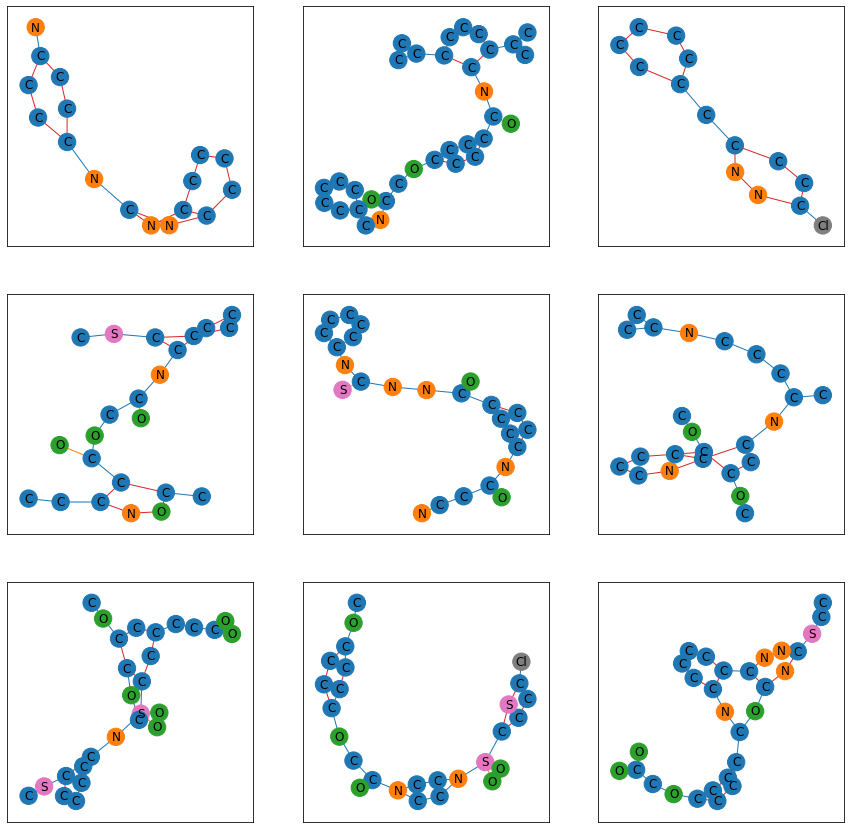

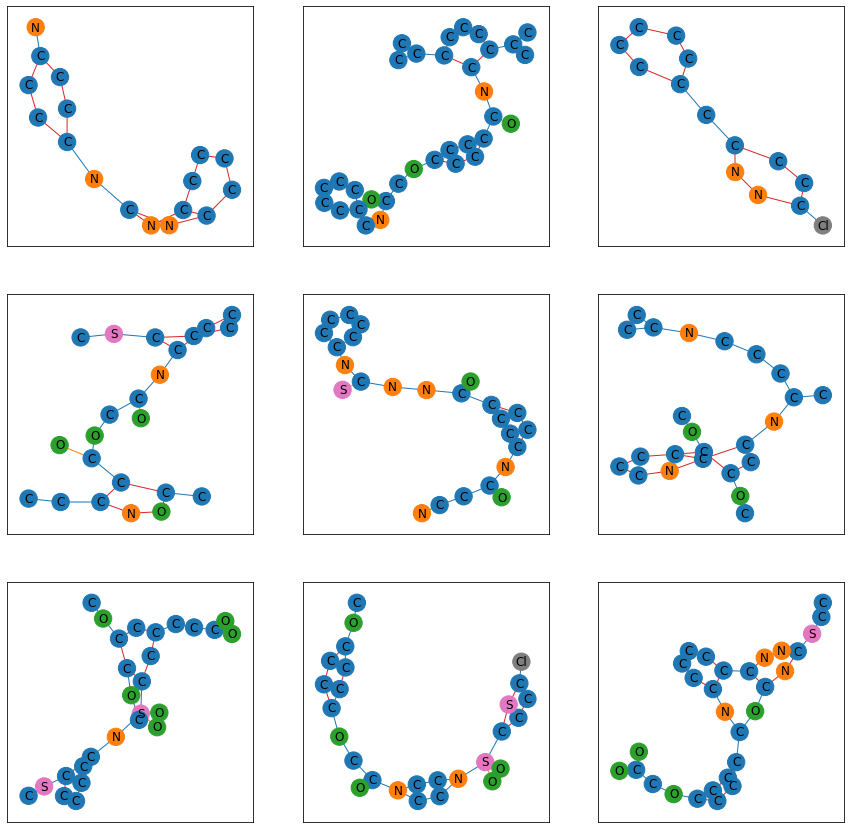

In [8]:
# Visualize examples from the training set.
# It takes a few minutes to download & prepare the dataset.
ds, ds_info = tfds.load('ogbg_molpcba', split='train', with_info=True)
tfds.visualization.show_examples(ds, ds_info,
                                 node_color_fn=node_color_fn,
                                 node_label_fn=node_label_fn,
                                 edge_color_fn=edge_color_fn)

## Training

In [ ]:
# Start TensorBoard
# Get a live update during training - use the "refresh" button!
# (In Jupyter[lab] start "tensorboard" in the local directory instead.)
if 'google.colab' in str(get_ipython()):
  %load_ext tensorboard
  %tensorboard --logdir=.

In [10]:
# Training loop

# Use a Colab GPU runtime to speed up training.
# We don't use TPUs in this Colab because we do not distribute our
# training using pmap() - if you're looking for an example using TPUs
# checkout the below Colab notebook:
# https://colab.research.google.com/github/google/flax/blob/main/examples/imagenet/imagenet.ipynb

config.num_train_steps = 1000
config.log_every_steps = 500
config.eval_every_steps = 500

# Construct the model and start the main training loop.
# The default config corresponds to a 5-layer Graph Convolutional Model
# with skip-connections and mean-pooling.
state = train.train_and_evaluate(config, workdir=f'./models')

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:absl:Hyperparameters: {'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': False, 'batch_size': 256, 'checkpoint_every_steps': 10000, 'dropout_rate': 0.1, 'eval_every_steps': 500, 'latent_size': 256, 'layer_norm': True, 'learning_rate': 0.001, 'log_every_steps': 500, 'message_passing_steps': 5, 'model': 'GraphConvNet', 'num_classes': 128, 'num_mlp_layers': 2, 'num_train_steps': 1000, 'optimizer': 'adam', 'skip_connections': True}
INFO:absl:Obtaining datasets.
INFO:absl:Load dataset info from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Reusing dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Construct

In [11]:
#@title Upload to TensorBoard.dev
if 'google.colab' in str(get_ipython()):
  #@markdown You can upload the training results directly to [TensorBoard.dev](https://tensorboard.dev).
  #@markdown
  #@markdown Note that anyone with the link will be able to see the data.
  upload_data = 'no' #@param ['yes', 'no']
  if upload_data == 'yes':
    !tensorboard dev upload --one_shot --logdir ./models --name 'Flax examples/ogbg_molpcba'

## Inference

In [12]:
# Create deterministic evaluation model.
eval_net = train.create_model(config, deterministic=True)
eval_state = state.replace(apply_fn=eval_net.apply)

In [13]:
# Compute accuracy and mean average precision on validation and test sets.
datasets = input_pipeline.get_datasets(
    config.batch_size,
    add_virtual_node=config.add_virtual_node,
    add_undirected_edges=config.add_undirected_edges,
    add_self_loops=config.add_self_loops)
eval_metrics = train.evaluate_model(eval_state, datasets,
                                    splits=['validation', 'test'])

INFO:absl:Load dataset info from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Reusing dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split train, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split validation, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split test, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2


In [14]:
for split in ['validation', 'test']:
  split_metrics = eval_metrics[split].compute()
  print(split)
  for metric_name, metric in split_metrics.items():
    print(f'- {metric_name}: {metric:.3f}')

validation
- accuracy: 0.984
- loss: 0.063
- mean_average_precision: 0.050
test
- accuracy: 0.983
- loss: 0.065
- mean_average_precision: 0.050


In [15]:
# Helper functions for formatting labels and predictions.
def get_formatted_label_for_task(labels, task):
  label_for_task = labels[task]
  if np.isnan(label_for_task):
    return 'Unknown'
  elif label_for_task == 0:
    return 'Inactive'
  elif label_for_task == 1:
    return 'Active'
  raise ValueError('Invalid label.')

# Predictions are computed with a threshold of 0 for the logits.
# This is the same threshold used to compute the accuracy.
def get_formatted_prediction_for_task(logits, task):
  predictions = logits > 0
  prediction_for_task = predictions[task]
  if prediction_for_task == 0:
    return 'Inactive'
  elif prediction_for_task == 1:
    return 'Active'
  raise ValueError('Invalid prediction.')

We can choose one of the 128 different tasks and see how the model predictions
match up with the true labels.

You can change this visualization to use any of the 128 tasks in this dataset, by changing the `task` variable below.  See the appendix [here](https://arxiv.org/pdf/1502.02072.pdf) to understand what these tasks mean.

The default is task PCBA-686978 (indexed at 93).

In [16]:
# Define which task to plot labels for.
task = 93

INFO:absl:Load dataset info from /root/tensorflow_datasets/ogbg_molpcba/0.1.2
INFO:absl:Reusing dataset ogbg_molpcba (/root/tensorflow_datasets/ogbg_molpcba/0.1.2)
INFO:absl:Constructing tf.data.Dataset ogbg_molpcba for split test, from /root/tensorflow_datasets/ogbg_molpcba/0.1.2


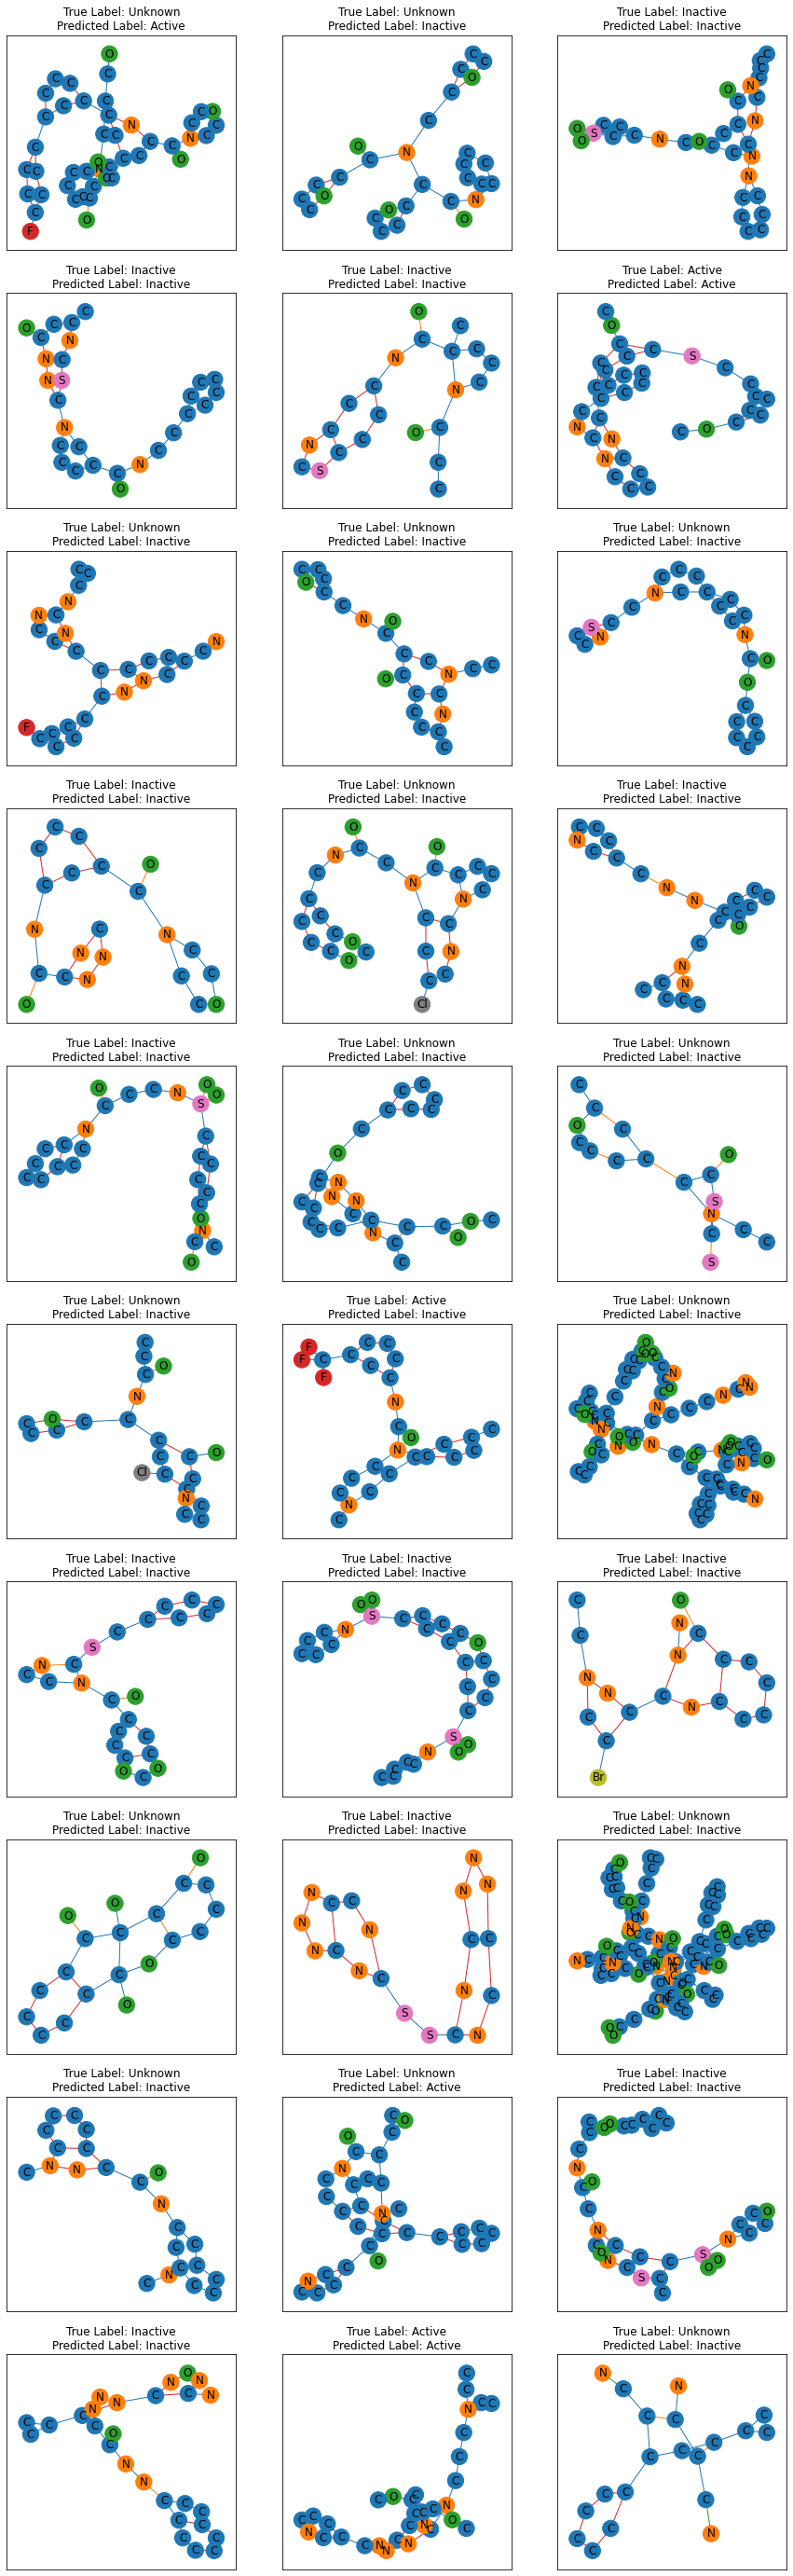

In [17]:
# Take a batch of graphs from the test set, and compute predictions.
graphs = next(datasets['test'].take(1).as_numpy_iterator())
labels = graphs.globals
logits = train.get_predicted_logits(eval_state, graphs, rngs=None)
graphs = jraph.unbatch(graphs)

# Create plot to visualize individual molecules.
ds, ds_info = tfds.load('ogbg_molpcba', split='test', with_info=True)
fig = tfds.visualization.show_examples(ds, ds_info,
                                       node_color_fn=node_color_fn,
                                       node_label_fn=node_label_fn,
                                       edge_color_fn=edge_color_fn,
                                       rows=10)

# Update plot titles with true and predicted labels.
for graph, graph_labels, graph_logits, ax in zip(graphs, labels, logits, fig.axes):
  label_for_task = get_formatted_label_for_task(graph_labels, task)
  predicted_label_for_task = get_formatted_prediction_for_task(graph_logits, task)
  ax.set_title(f'True Label: {label_for_task}\n'
               f'Predicted Label: {predicted_label_for_task}')